### TAKEHOME 2 - HIERARCHICAL CLUSTERING

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [2]:
df = pd.read_csv("hierarchical_robot_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   joint_velocity_mean  900 non-null    float64
 1   joint_velocity_std   900 non-null    float64
 2   torque_mean          900 non-null    float64
 3   torque_std           900 non-null    float64
 4   imu_energy           900 non-null    float64
dtypes: float64(5)
memory usage: 35.3 KB


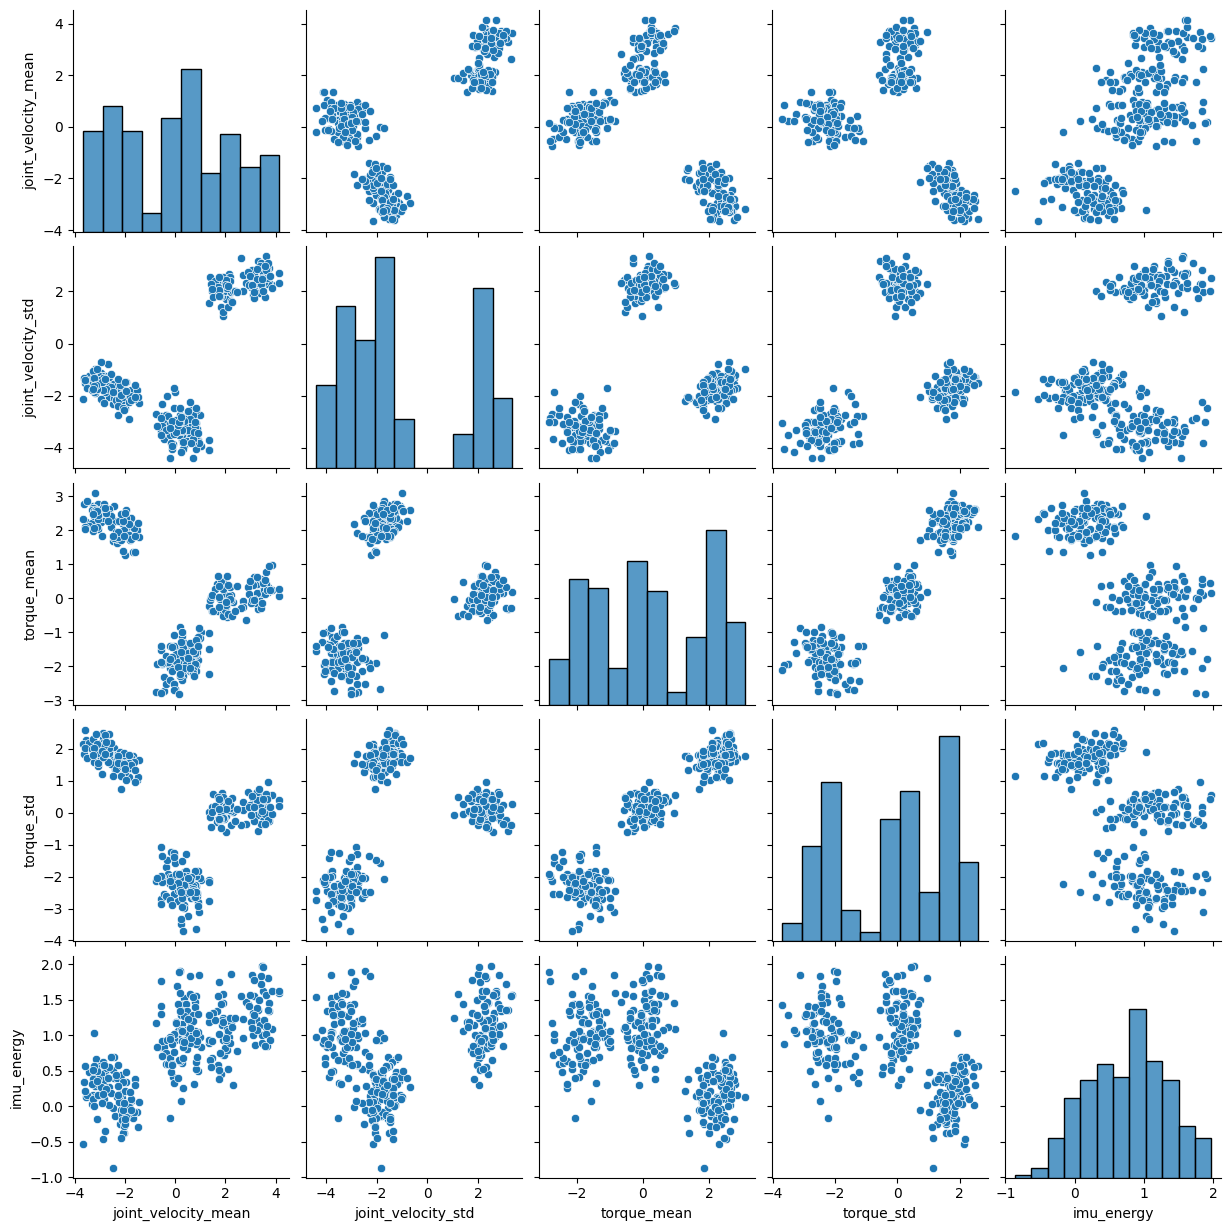

In [3]:
sns.pairplot(df.sample(300))
plt.show()

hierarchical clustering is distance-based so scale matters<br>
without standardization, high-variance features dominate the distance calculation

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

## Building the Model

linkage methods define distance between clusters:
for any two points from diff clusters
- single ->  min distance between  them
- complete -> max dsitance between them
- average -> mean of distances
- ward -> minimize increase in within-cluster variance

ward minimizes variance increase at each merge<br>
same objective as k-means but hierarchical instead of iterative reassignment

greedy algorithm - once merged, never separated<br>
early mistakes just expand as go upward

In [5]:
Z = linkage(X_scaled, method="ward")

# Z is linkage matrix
# each row: [cluster_i, cluster_j, distance, sample_count]
# n-1 rows for n samples

dendrogram height = merge distance<br>
large vertical jumps = natural cluster boundaries<br>
p controls tree depth shown - higher p shows more detail

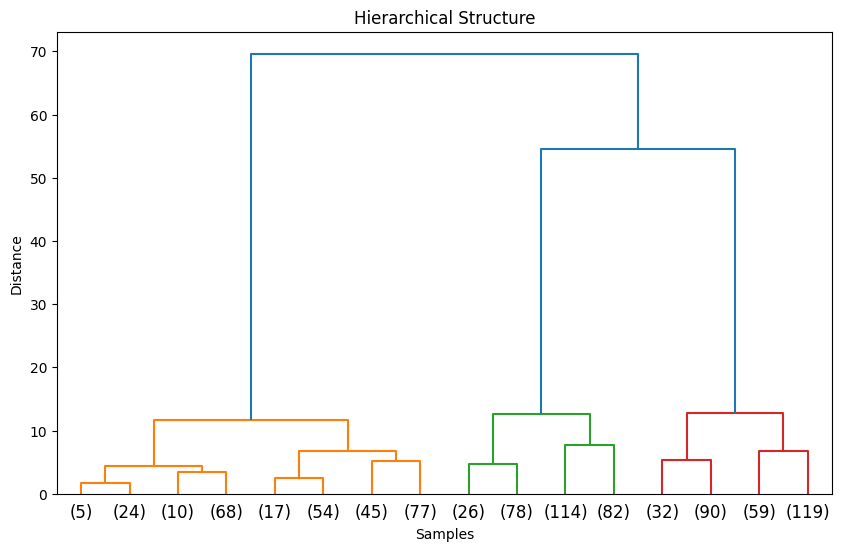

In [6]:
plt.figure(figsize=(10,6))
dendrogram(Z, truncate_mode="level", p=3)
plt.title("Hierarchical Structure")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

## Cutting with number of clusters

fcluster cuts the tree at different resolutions<br>
- t=3, criterion="maxclust" -> exactly 3 clusters
- t=7, criterion="distance" -> cut at distance 7

same hierarchy gives both macro and micro structure

In [7]:
macro_clusters = fcluster(Z, t=3, criterion="maxclust")
df["macro_cluster"] = macro_clusters

print(df["macro_cluster"].value_counts())

macro_cluster
2    300
1    300
3    300
Name: count, dtype: int64


In [8]:
micro_clusters = fcluster(Z, t=6, criterion="maxclust")
df["micro_cluster"] = micro_clusters

print(df["micro_cluster"].value_counts())

micro_cluster
4    196
2    193
6    178
5    122
1    107
3    104
Name: count, dtype: int64


pca just for visualization in lower dimensions- clusters already exist from hierarchical algo<br>
s = scatter point size

In [9]:
pca = PCA(n_components=2) #2D here
X_pca = pca.fit_transform(X_scaled)

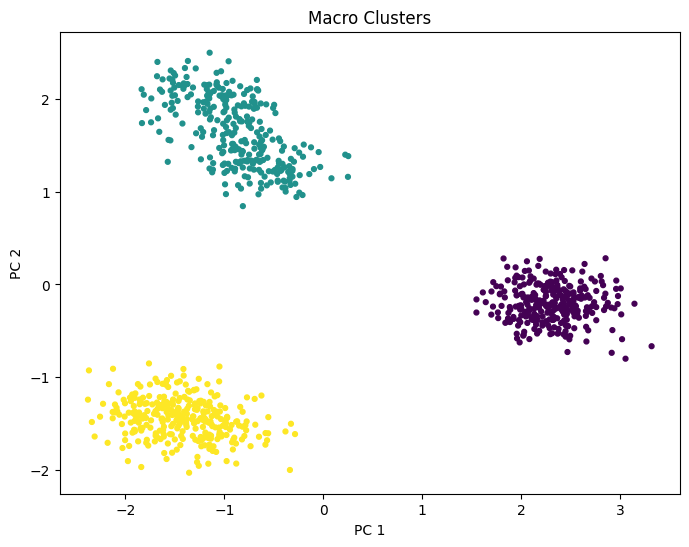

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=macro_clusters, s=12)
plt.title("Macro Clusters")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

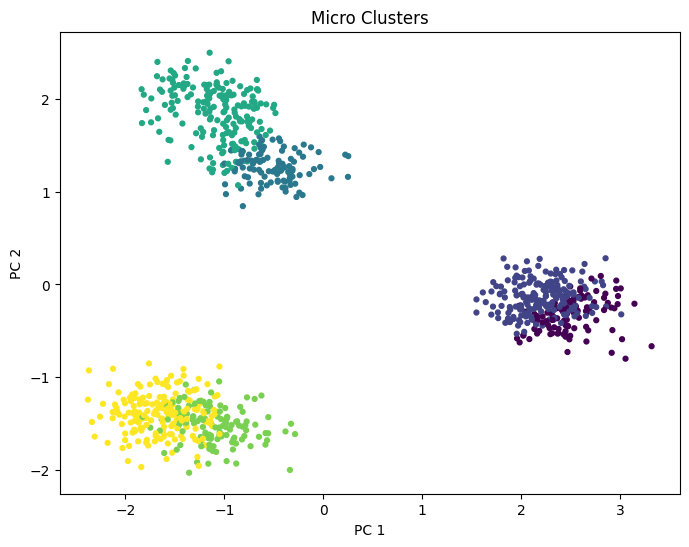

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=micro_clusters,s=12)
plt.title("Micro Clusters")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

feature means show what defines each cluster<br>
high joint_velocity + low torque -> fast ovements<br>
low velocity + high torque -> slow movements

In [12]:
print(df.groupby("macro_cluster").mean())
print("\n")
print(df.groupby("micro_cluster").mean())

               joint_velocity_mean  joint_velocity_std  torque_mean  \
macro_cluster                                                         
1                        -2.477360           -1.750310     2.238128   
2                         2.748894            2.252349     0.114902   
3                         0.230322           -3.271859    -1.754592   

               torque_std  imu_energy  micro_cluster  
macro_cluster                                         
1                1.738448    0.173521       1.643333  
2                0.123880    1.145812       3.653333  
3               -2.254968    1.063447       5.593333  


               joint_velocity_mean  joint_velocity_std  torque_mean  \
micro_cluster                                                         
1                        -2.194005           -1.856562     2.134432   
2                        -2.634453           -1.691404     2.295618   
3                         1.993867            1.970133    -0.075621   
4           

## Cutting with distance threshold

instead of k clusters, cut at distance threshold<br>
lower t -> more clusters, higher t -> fewer clusters<br>
reveals natural structure from geometry not arbitrary k

In [13]:
distance_clusters = fcluster(Z, t=7, criterion="distance")
df["distance_cluster"] = distance_clusters

print(df["distance_cluster"].value_counts())

distance_cluster
2    193
7    178
6    122
4    114
1    107
3    104
5     82
Name: count, dtype: int64


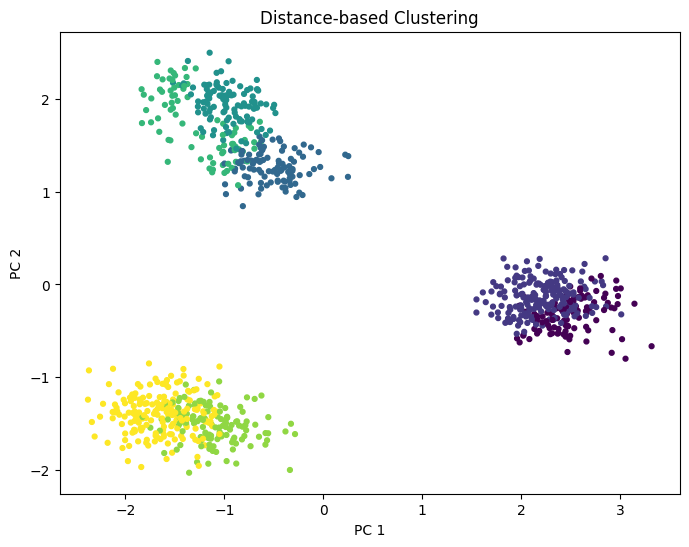

In [14]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=distance_clusters,s=12)
plt.title("Distance-based Clustering")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

In [15]:
df.to_csv("hierarchical_robot_data_with_clusters.csv", index=False)

used when we dont know k before hand or want multi-scale representation<br>
because computationally expensive cant be used with larger samples 
